# Importing Requried Libraries

In [142]:
import torch 
import os
import numpy as np 
import cv2
from torchvision.models.vision_transformer import VisionTransformer
from ViT import ViT
from torch import Tensor
from torch import nn,optim
from torch.utils.data import DataLoader,TensorDataset
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm

if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

# Import Features

In [144]:
import pickle
with open("Features/img_data.pkl", "rb") as f:
    image_data = pickle.load(f)
with open ("Features/labels.pkl","rb") as f:
    labels = pickle.load(f)

In [145]:
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 50

In [146]:
# image_data = np.array(image_data)
# labels = np.array(labels.cpu())
type(image_data),type(labels)

(numpy.ndarray, numpy.ndarray)

In [147]:
image_data.shape, labels.shape

((6253, 224, 224, 3), (6253,))

In [148]:
labels

array([0, 0, 0, ..., 1, 1, 1])

### Take only 1000 Image Data

In [150]:
first_500_images = image_data[:500]
last_500_images = image_data[-500:]
images_subset = np.concatenate([first_500_images,last_500_images],axis = 0)

first_500_labels = labels[:500]
last_500_labels = labels[-500:]
labels_subset = np.concatenate([first_500_labels,last_500_labels],axis = 0)

images_subset.shape, labels_subset.shape

((1000, 224, 224, 3), (1000,))

In [151]:
val_first_500_images = image_data[500:1000]
val_last_500_images = image_data[-1000:-500]
val_images_subset = np.concatenate([val_first_500_images,val_last_500_images],axis = 0)

val_first_500_labels = labels[500:1000]
val_last_500_labels = labels[-1000:-500]
val_labels_subset = np.concatenate([val_first_500_labels, val_last_500_labels], axis=0)

val_images_subset.shape, val_labels_subset.shape

((1000, 224, 224, 3), (1000,))

In [152]:
image_data_tensors = Tensor(images_subset)
labels_tensors = Tensor(labels_subset)
val_image_data_tensors = Tensor(val_images_subset)
val_labels_tensors = Tensor(val_labels_subset)



In [153]:
import torch.nn.functional as F
labels_tensors = labels_tensors.to(torch.int64)
labels_tensors = F.one_hot(labels_tensors, num_classes=2).float()
val_labels_tensors = val_labels_tensors.to(torch.int64)
val_labels_tensors = F.one_hot(val_labels_tensors,num_classes=2).float()

One Hot Encoding 

In [155]:
labels_tensors, val_labels_tensors

(tensor([[1., 0.],
         [1., 0.],
         [1., 0.],
         ...,
         [0., 1.],
         [0., 1.],
         [0., 1.]]),
 tensor([[1., 0.],
         [1., 0.],
         [1., 0.],
         ...,
         [0., 1.],
         [0., 1.],
         [0., 1.]]))

In [156]:
print(f"Shape of the Image Data : {image_data_tensors.shape}")
print(f"Shape of the Labels : {labels_tensors.shape}")
print("--------------------------------------------------------")
print(f"Shape of the Validation Image Data : {val_image_data_tensors.shape}")
print(f"Shape of the Validation Labels : {val_labels_tensors.shape}")


Shape of the Image Data : torch.Size([1000, 224, 224, 3])
Shape of the Labels : torch.Size([1000, 2])
--------------------------------------------------------
Shape of the Validation Image Data : torch.Size([1000, 224, 224, 3])
Shape of the Validation Labels : torch.Size([1000, 2])


# Loading the Input to GPU

In [158]:
inputs = image_data_tensors.to(device)
labels = labels_tensors.to(device)

# Model Training:

### Creating Model

In [161]:
vit_model = VisionTransformer(
    image_size=224,
    patch_size=16,
    num_layers=2,
    num_heads=2,
    hidden_dim=128,
    mlp_dim=256,
    dropout=0.20,
)
seq_vit_model = torch.nn.Sequential(
    vit_model,
    nn.Linear(1000,2),
    nn.Sigmoid()
)
seq_vit_model.to(device)
seq_vit_model

Sequential(
  (0): VisionTransformer(
    (conv_proj): Conv2d(3, 128, kernel_size=(16, 16), stride=(16, 16))
    (encoder): Encoder(
      (dropout): Dropout(p=0.2, inplace=False)
      (layers): Sequential(
        (encoder_layer_0): EncoderBlock(
          (ln_1): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
          (self_attention): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
          )
          (dropout): Dropout(p=0.2, inplace=False)
          (ln_2): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
          (mlp): MLPBlock(
            (0): Linear(in_features=128, out_features=256, bias=True)
            (1): GELU(approximate='none')
            (2): Dropout(p=0.2, inplace=False)
            (3): Linear(in_features=256, out_features=128, bias=True)
            (4): Dropout(p=0.2, inplace=False)
          )
        )
        (encoder_layer_1): EncoderBlock(
          (ln_1): LayerNorm(

### Defining Loss Functions

In [165]:
LOSS_FUNCTION = torch.nn.CrossEntropyLoss()
OPTIMIZER = torch.optim.Adam(seq_vit_model.parameters(), lr=1e-4)

### Creating the DataLoader

In [167]:
dataset = torch.utils.data.TensorDataset(image_data_tensors, labels_tensors)
data_loader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

In [168]:
val_dataset = torch.utils.data.TensorDataset(val_image_data_tensors, val_labels_tensors)
val_data_loader = torch.utils.data.DataLoader(val_dataset, batch_size = BATCH_SIZE, shuffle = True)

# Model Training

In [170]:
history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

for epoch in range(EPOCHS):
    # Training phase
    seq_vit_model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in tqdm(data_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Train]"):
        images, labels = images.to(device), labels.to(device)
        images = images.permute(0, 3, 1, 2)  # Ensure correct shape for model input

        OPTIMIZER.zero_grad()  # Clear gradients
        outputs = seq_vit_model(images)  # Forward pass

        # Compute loss
        loss = LOSS_FUNCTION(outputs, labels)
        loss.backward()  # Backpropagation
        OPTIMIZER.step()  # Update weights

        # Update training metrics
        train_loss += loss.item()
        correct_train += (outputs.argmax(dim=1) == labels.argmax(dim=1)).sum().item()
        total_train += labels.size(0)

    train_loss /= len(data_loader)
    train_acc = correct_train / total_train
    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)

    # Validation phase
    seq_vit_model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for images, labels in tqdm(val_data_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Val]"):
            images, labels = images.to(device), labels.to(device)
            images = images.permute(0, 3, 1, 2)

            outputs = seq_vit_model(images)

            # Compute loss
            loss = LOSS_FUNCTION(outputs, labels)
            val_loss += loss.item()

            # Update validation metrics
            correct_val += (outputs.argmax(dim=1) == labels.argmax(dim=1)).sum().item()
            total_val += labels.size(0)

    val_loss /= len(val_data_loader)
    val_acc = correct_val / total_val
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)

    # Print epoch summary
    print(f"Epoch {epoch+1}/{EPOCHS}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")


Epoch 1/50 [Val]: 100%|██████████| 32/32 [00:00<00:00, 38.15it/s]


Epoch 1/50, Train Loss: 0.6618, Train Acc: 0.6570, Val Loss: 0.6797, Val Acc: 0.5750


Epoch 2/50 [Val]: 100%|██████████| 32/32 [00:00<00:00, 67.91it/s]


Epoch 2/50, Train Loss: 0.5422, Train Acc: 0.7690, Val Loss: 0.7079, Val Acc: 0.5810


Epoch 3/50 [Val]: 100%|██████████| 32/32 [00:00<00:00, 74.78it/s]


Epoch 3/50, Train Loss: 0.5103, Train Acc: 0.7910, Val Loss: 0.7033, Val Acc: 0.5900


Epoch 4/50 [Val]: 100%|██████████| 32/32 [00:00<00:00, 69.55it/s]


Epoch 4/50, Train Loss: 0.4931, Train Acc: 0.8120, Val Loss: 0.7302, Val Acc: 0.5730


Epoch 5/50 [Val]: 100%|██████████| 32/32 [00:00<00:00, 81.51it/s]


Epoch 5/50, Train Loss: 0.4828, Train Acc: 0.8260, Val Loss: 0.7465, Val Acc: 0.5550


Epoch 6/50 [Val]: 100%|██████████| 32/32 [00:00<00:00, 73.31it/s]


Epoch 6/50, Train Loss: 0.4816, Train Acc: 0.8360, Val Loss: 0.7301, Val Acc: 0.5770


Epoch 7/50 [Val]: 100%|██████████| 32/32 [00:00<00:00, 66.47it/s]


Epoch 7/50, Train Loss: 0.4877, Train Acc: 0.8280, Val Loss: 0.7729, Val Acc: 0.5360


Epoch 8/50 [Val]: 100%|██████████| 32/32 [00:00<00:00, 65.55it/s]


Epoch 8/50, Train Loss: 0.4773, Train Acc: 0.8380, Val Loss: 0.7178, Val Acc: 0.5920


Epoch 9/50 [Val]: 100%|██████████| 32/32 [00:00<00:00, 68.21it/s]


Epoch 9/50, Train Loss: 0.4873, Train Acc: 0.8240, Val Loss: 0.7732, Val Acc: 0.5390


Epoch 10/50 [Val]: 100%|██████████| 32/32 [00:00<00:00, 60.82it/s]


Epoch 10/50, Train Loss: 0.4729, Train Acc: 0.8340, Val Loss: 0.7318, Val Acc: 0.5770


Epoch 11/50 [Val]: 100%|██████████| 32/32 [00:00<00:00, 63.10it/s]


Epoch 11/50, Train Loss: 0.4737, Train Acc: 0.8380, Val Loss: 0.7139, Val Acc: 0.5940


Epoch 12/50 [Val]: 100%|██████████| 32/32 [00:00<00:00, 68.18it/s]


Epoch 12/50, Train Loss: 0.4763, Train Acc: 0.8310, Val Loss: 0.7314, Val Acc: 0.5830


Epoch 13/50 [Val]: 100%|██████████| 32/32 [00:00<00:00, 66.03it/s]


Epoch 13/50, Train Loss: 0.4710, Train Acc: 0.8370, Val Loss: 0.7280, Val Acc: 0.5850


Epoch 14/50 [Val]: 100%|██████████| 32/32 [00:00<00:00, 66.57it/s]


Epoch 14/50, Train Loss: 0.4724, Train Acc: 0.8430, Val Loss: 0.7363, Val Acc: 0.5740


Epoch 15/50 [Val]: 100%|██████████| 32/32 [00:00<00:00, 62.93it/s]


Epoch 15/50, Train Loss: 0.4792, Train Acc: 0.8330, Val Loss: 0.7407, Val Acc: 0.5660


Epoch 16/50 [Val]: 100%|██████████| 32/32 [00:00<00:00, 82.17it/s]


Epoch 16/50, Train Loss: 0.4666, Train Acc: 0.8410, Val Loss: 0.7488, Val Acc: 0.5620


Epoch 17/50 [Val]: 100%|██████████| 32/32 [00:00<00:00, 81.19it/s]


Epoch 17/50, Train Loss: 0.4702, Train Acc: 0.8420, Val Loss: 0.7043, Val Acc: 0.6030


Epoch 18/50 [Val]: 100%|██████████| 32/32 [00:00<00:00, 65.41it/s]


Epoch 18/50, Train Loss: 0.4667, Train Acc: 0.8460, Val Loss: 0.6585, Val Acc: 0.6410


Epoch 19/50 [Val]: 100%|██████████| 32/32 [00:00<00:00, 60.95it/s]


Epoch 19/50, Train Loss: 0.4741, Train Acc: 0.8390, Val Loss: 0.7438, Val Acc: 0.5700


Epoch 20/50 [Val]: 100%|██████████| 32/32 [00:00<00:00, 73.20it/s]


Epoch 20/50, Train Loss: 0.4633, Train Acc: 0.8510, Val Loss: 0.7049, Val Acc: 0.6000


Epoch 21/50 [Val]: 100%|██████████| 32/32 [00:00<00:00, 64.98it/s]


Epoch 21/50, Train Loss: 0.4764, Train Acc: 0.8420, Val Loss: 0.7341, Val Acc: 0.5760


Epoch 22/50 [Val]: 100%|██████████| 32/32 [00:00<00:00, 66.12it/s]


Epoch 22/50, Train Loss: 0.4578, Train Acc: 0.8500, Val Loss: 0.7160, Val Acc: 0.5910


Epoch 23/50 [Val]: 100%|██████████| 32/32 [00:00<00:00, 72.88it/s]


Epoch 23/50, Train Loss: 0.4531, Train Acc: 0.8550, Val Loss: 0.7208, Val Acc: 0.5920


Epoch 24/50 [Val]: 100%|██████████| 32/32 [00:00<00:00, 66.48it/s]


Epoch 24/50, Train Loss: 0.4589, Train Acc: 0.8540, Val Loss: 0.7104, Val Acc: 0.5910


Epoch 25/50 [Val]: 100%|██████████| 32/32 [00:00<00:00, 62.04it/s]


Epoch 25/50, Train Loss: 0.4501, Train Acc: 0.8620, Val Loss: 0.7360, Val Acc: 0.5680


Epoch 26/50 [Val]: 100%|██████████| 32/32 [00:00<00:00, 63.49it/s]


Epoch 26/50, Train Loss: 0.4522, Train Acc: 0.8610, Val Loss: 0.7075, Val Acc: 0.6030


Epoch 27/50 [Val]: 100%|██████████| 32/32 [00:00<00:00, 60.10it/s]


Epoch 27/50, Train Loss: 0.4518, Train Acc: 0.8600, Val Loss: 0.7278, Val Acc: 0.5810


Epoch 28/50 [Val]: 100%|██████████| 32/32 [00:00<00:00, 63.85it/s]


Epoch 28/50, Train Loss: 0.4431, Train Acc: 0.8640, Val Loss: 0.7205, Val Acc: 0.5930


Epoch 29/50 [Val]: 100%|██████████| 32/32 [00:00<00:00, 69.41it/s]


Epoch 29/50, Train Loss: 0.4443, Train Acc: 0.8700, Val Loss: 0.7297, Val Acc: 0.5750


Epoch 30/50 [Val]: 100%|██████████| 32/32 [00:00<00:00, 63.17it/s]


Epoch 30/50, Train Loss: 0.4417, Train Acc: 0.8700, Val Loss: 0.7147, Val Acc: 0.5900


Epoch 31/50 [Val]: 100%|██████████| 32/32 [00:00<00:00, 66.30it/s]


Epoch 31/50, Train Loss: 0.4308, Train Acc: 0.8780, Val Loss: 0.7145, Val Acc: 0.5990


Epoch 32/50 [Val]: 100%|██████████| 32/32 [00:00<00:00, 62.82it/s]


Epoch 32/50, Train Loss: 0.4362, Train Acc: 0.8730, Val Loss: 0.7423, Val Acc: 0.5710


Epoch 33/50 [Val]: 100%|██████████| 32/32 [00:00<00:00, 69.39it/s]


Epoch 33/50, Train Loss: 0.4441, Train Acc: 0.8690, Val Loss: 0.7377, Val Acc: 0.5610


Epoch 34/50 [Val]: 100%|██████████| 32/32 [00:00<00:00, 61.27it/s]


Epoch 34/50, Train Loss: 0.4459, Train Acc: 0.8560, Val Loss: 0.7382, Val Acc: 0.5690


Epoch 35/50 [Val]: 100%|██████████| 32/32 [00:00<00:00, 73.81it/s]


Epoch 35/50, Train Loss: 0.4336, Train Acc: 0.8790, Val Loss: 0.7313, Val Acc: 0.5760


Epoch 36/50 [Val]: 100%|██████████| 32/32 [00:00<00:00, 65.86it/s]


Epoch 36/50, Train Loss: 0.4260, Train Acc: 0.8820, Val Loss: 0.7227, Val Acc: 0.5910


Epoch 37/50 [Val]: 100%|██████████| 32/32 [00:00<00:00, 67.80it/s]


Epoch 37/50, Train Loss: 0.4287, Train Acc: 0.8850, Val Loss: 0.7352, Val Acc: 0.5790


Epoch 38/50 [Val]: 100%|██████████| 32/32 [00:00<00:00, 67.57it/s]


Epoch 38/50, Train Loss: 0.4193, Train Acc: 0.8920, Val Loss: 0.7197, Val Acc: 0.5890


Epoch 39/50 [Val]: 100%|██████████| 32/32 [00:00<00:00, 84.10it/s]


Epoch 39/50, Train Loss: 0.4302, Train Acc: 0.8850, Val Loss: 0.6916, Val Acc: 0.6080


Epoch 40/50 [Val]: 100%|██████████| 32/32 [00:00<00:00, 87.85it/s]


Epoch 40/50, Train Loss: 0.4260, Train Acc: 0.8880, Val Loss: 0.7480, Val Acc: 0.5580


Epoch 41/50 [Val]: 100%|██████████| 32/32 [00:00<00:00, 70.84it/s]


Epoch 41/50, Train Loss: 0.4250, Train Acc: 0.8910, Val Loss: 0.7133, Val Acc: 0.5970


Epoch 42/50 [Val]: 100%|██████████| 32/32 [00:00<00:00, 65.49it/s]


Epoch 42/50, Train Loss: 0.4215, Train Acc: 0.8870, Val Loss: 0.7450, Val Acc: 0.5660


Epoch 43/50 [Val]: 100%|██████████| 32/32 [00:00<00:00, 68.62it/s]


Epoch 43/50, Train Loss: 0.4215, Train Acc: 0.8910, Val Loss: 0.7313, Val Acc: 0.5850


Epoch 44/50 [Val]: 100%|██████████| 32/32 [00:00<00:00, 62.96it/s]


Epoch 44/50, Train Loss: 0.4170, Train Acc: 0.8930, Val Loss: 0.7178, Val Acc: 0.5890


Epoch 45/50 [Val]: 100%|██████████| 32/32 [00:00<00:00, 67.80it/s]


Epoch 45/50, Train Loss: 0.4203, Train Acc: 0.8920, Val Loss: 0.7114, Val Acc: 0.5910


Epoch 46/50 [Val]: 100%|██████████| 32/32 [00:00<00:00, 75.32it/s]


Epoch 46/50, Train Loss: 0.4275, Train Acc: 0.8860, Val Loss: 0.7611, Val Acc: 0.5550


Epoch 47/50 [Val]: 100%|██████████| 32/32 [00:00<00:00, 69.39it/s]


Epoch 47/50, Train Loss: 0.4208, Train Acc: 0.8960, Val Loss: 0.7471, Val Acc: 0.5690


Epoch 48/50 [Val]: 100%|██████████| 32/32 [00:00<00:00, 66.08it/s]


Epoch 48/50, Train Loss: 0.4255, Train Acc: 0.8860, Val Loss: 0.7418, Val Acc: 0.5720


Epoch 49/50 [Val]: 100%|██████████| 32/32 [00:00<00:00, 64.53it/s]


Epoch 49/50, Train Loss: 0.4206, Train Acc: 0.8920, Val Loss: 0.7084, Val Acc: 0.6010


Epoch 50/50 [Val]: 100%|██████████| 32/32 [00:00<00:00, 63.76it/s]


Epoch 50/50, Train Loss: 0.4117, Train Acc: 0.8990, Val Loss: 0.7353, Val Acc: 0.5750


In [193]:
import pandas as pd

In [208]:
vit_model_history = pd.DataFrame(history)
epochs = np.arange(1,51).reshape(-1,1)
vit_model_history["Epochs"] = epochs
vit_model_history

,train_loss,val_loss,train_acc,val_acc,Epochs
0,0.661801,0.679652,0.657,0.575,1
1,0.542184,0.707945,0.769,0.581,2
2,0.510345,0.703255,0.791,0.590,3
3,0.493115,0.730166,0.812,0.573,4
4,0.482779,0.746490,0.826,0.555,5
5,0.481643,0.730058,0.836,0.577,6
6,0.487741,0.772891,0.828,0.536,7
7,0.477323,0.717794,0.838,0.592,8
8,0.487341,0.773172,0.824,0.539,9
9,0.472890,0.731769,0.834,0.577,10


In [210]:
vit_model_history.to_csv("History/vit_model_history_pytorch.csv")


In [212]:
torch.save(seq_vit_model, "ViT Model Pytorch.pth")

In [214]:
import matplotlib.pyplot as plt
import seaborn as sns

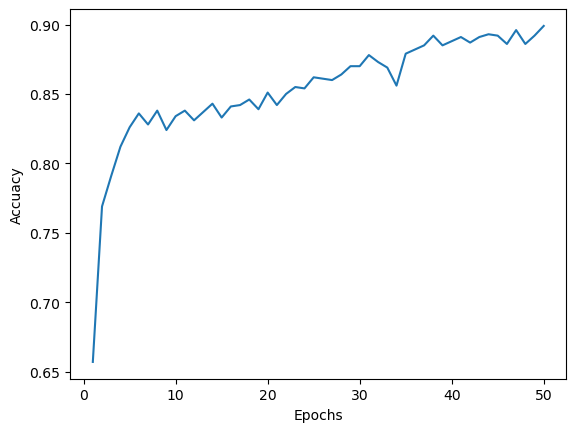

In [236]:
sns.lineplot(x = vit_model_history["Epochs"],y = vit_model_history["train_acc"])
plt.ylabel("Accuacy")
plt.show()

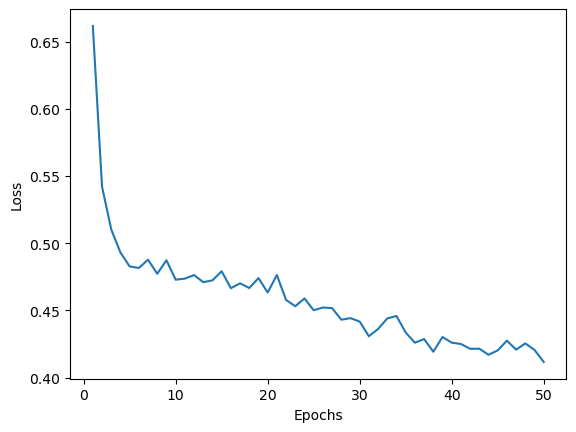

In [240]:
sns.lineplot(x = vit_model_history["Epochs"],y = vit_model_history["train_loss"])
plt.ylabel("Loss")
plt.show()